In [4]:
from mindquantum.core.circuit import Circuit, UN, add_suffix, apply, decompose_single_term_time_evolution
from mindquantum.core.gates import H, Rzz, RX, Rzz,RZ, RY, Measure, BarrierGate
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
from mindquantum.core.operators import commutator
import time
from mindquantum.core.parameterresolver import ParameterResolver
from mindquantum import *

import mindspore.nn as nn
from mindspore import Tensor
import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import matplotlib.pylab as pylab
from tqdm import tqdm

from itertools import combinations
from collections import OrderedDict as ordict


## Build quantum circuits

In [5]:
def param2dict(keys, values):
    # make the parameters and coresponding label to a dict
    param_dict = {}
    for (key, value) in zip(keys, values):
        param_dict[key] = value
    return param_dict

def get_expectation_of_hamitonian(circ, ham, pr):
    # calculate the expectation of hamitonian
    sim = Simulator('mqvector', circ.n_qubits)
    sim.apply_circuit(circ, pr)
    result = sim.get_expectation(ham)
        
    return result.real

def E0_energy(ham_operator):
    
    # 首先根据哈密顿量的算符将其转化为矩阵形式。
    ham_matrix = ham_operator.matrix()
    ham_matrix = ham_matrix.todense()

    # calculate the eigenvalue and eigenvector
    eigval, eigvec = np.linalg.eig(ham_matrix)

    # 找到最小特征值的索引
    min_index = np.argmin(eigval)

    # 获取对应的特征向量
    min_eigvec = eigvec[:, min_index]

    return min_eigvec,eigval[min_index]

def train(ham, ansatze, iteration):

    # bulid the quantum circuit
    
    circ = ansatze                                         # 将初始化线路与ansatz线路组合成一个线路
    sim = Simulator('mqvector', ansatze.n_qubits)  
    #sim.set_qs(initial_ground_state)
    
    grad_ops = sim.get_expectation_with_grad(ham, circ)    # 获取计算变分量子线路的期望值和梯度的算子
    net = MQAnsatzOnlyLayer(grad_ops)                             
    opti = nn.Adam(net.trainable_params(), learning_rate=0.05)     
    train_net = nn.TrainOneStepCell(net, opti)                    

    result = []
    #from tqdm import tqdm
    for i in range(iteration):
        train_net() 
        result.append(train_net()[0])
    pr = dict(zip(ansatze.params_name, net.weight.asnumpy())) # 获取线路参数
        
    return pr, result


def state_sampling(ansatze, pr):
    
    shots = 1024

    for i in range(ansatze.n_qubits):
        ansatze += Measure().on(i)
    

    sim = Simulator('mqvector', ansatze.n_qubits)
    #sim.set_qs(initial_ground_state)
    res = sim.sampling(ansatze, pr, shots=shots)
    
    return res


def CD_operator(CD):
    
    CD_term = []
    for cd in CD.split():
        CD_term.append(cd[1])
    k = 0
    out = ordict()
    for cd in CD_term:
        for key, term in cd.terms.items():
            if len(key) == 2:
                #print(len(key))
                if key not in out:
                    out[key] = ordict({f"p{k}": 1})
                    k += 1
    return out

def CD_ansataz(out):
    "Transform a pauli ansatz to parameterized quantum circuit."

    circuit = Circuit()
    # circuit += inital_circuits(occupied, circuit_description)
        
    z = 0
    for k, v in out.items():
        index1 = (k[0][0], k[1][0])
        index2 = (k[1][0], k[0][0])

        pauli_operator = (str(k[0][1]), str(k[1][1]))
        if pauli_operator == ('Z','Y'):
            circuit += Ryz(f'{z}').on(index2)          
            z+=1
    # for k, v in out.items():
    #     circuit += decompose_single_term_time_evolution(k, v)
    for i in range(n_items):
        circuit += RY(f'ry{i}').on(i)
    
    return circuit

### The Hamitonian 
$H_p = \sum_{i=1}^{n}(-\frac{\alpha}{2}+\beta(C-\frac{1}{2}\sum_{i}^{n}\omega_{i}))Z_{i}\omega_{i} + \sum_{i<j}\frac{\beta}{2}\omega_{i}\omega_{j}Z_{i}Z_{j}.$

In [6]:
def generate_h_one_body(n, W, alpha, beta, capacity):
    ele1 = QubitOperator()
    for i in range(n):
            ele1 += QubitOperator(f'Z{i}',-W[i]*(alpha/2 - beta*capacity))
    for i in range(n):
        for j in range(n):
            ele1 += QubitOperator(f'Z{i}',-1/2*beta*W[i]*W[j])
    return ele1

def generate_h_two_body(n, W, beta):
    ele1 = QubitOperator()
    h_two_body = QubitOperator()
    for i in range(n):
        for j in range(n):
            if i < j:
                ele1 += QubitOperator(f'Z{i} Z{j}',W[i]*W[j]*beta/2)
    return ele1

def generate_h_mixer(n):
    h_mixer = QubitOperator()
    for i in range(n):
        h_mixer += QubitOperator(f'X{i}')
    return h_mixer

In [7]:
# Function of generating all possible solution in one bin
def find_combinations(elements, target_sum):
    result = []
    # Enumerate the elements to keep track of their indices
    enumerated_elements = list(enumerate(elements))
    for r in range(1, len(elements) + 1):
        for combo in combinations(enumerated_elements, r):
            # Calculate the sum of the current combination
            combo_sum = sum(ele[1] for ele in combo)
            if combo_sum <= target_sum:
                # Store the indices of the elements in the combination
                result.append([ele[0] for ele in combo])
    return result


# Function of calculating the minimum positive difference of weights
def min_positive_difference(lst):
    # Sort the list in ascending order
    sorted_lst = sorted(lst)
    
    # Initialize min_diff to a large value
    min_diff = float('inf')

    # Iterate through the sorted list to find the minimum positive difference
    for i in range(len(sorted_lst) - 1):
        diff = sorted_lst[i + 1] - sorted_lst[i]
        if 0 < diff < min_diff:
            min_diff = diff

    return min_diff if min_diff != float('inf') else None

### check the minimum number of bin

In [8]:
def find_min_number(lists, target):
    opti_solu = 0
    for n in tqdm(range(n_items)):
        nested_list = list(combinations(lists,n))
        for sublist in nested_list:
            l = []
            for i in sublist:
                l+=i
                l = sorted(l)
                if l==target:
                    opti_solu += 1
        if opti_solu != 0:
            return n, opti_solu
            break
    return 999, 999

### define the traing process, including optimizer, iteration

In [9]:
def Quantum_cd_mixer(h_m, ci, n_layer, n_items):
       
    u_m = 0
    index=0
    for i in h_m:
        u_m += decompose_single_term_time_evolution(i, ParameterResolver(f'c{index}'))
        index=index+1

    p = n_layer
    prep_circ = UN(H, n_items)
    ansatz_template =   u_m + ci #u_p +
    ansatz = Circuit() + prep_circ

    for i in range(p):
        ansatz += add_suffix(ansatz_template, str(i)) + BarrierGate()
        
    return ansatz

def Quantum_cd_QAOA(h_m, h_p, ci, n_layer, n_items):
       
    u_m = 0
    index=0
    for i in h_m:
        u_m += decompose_single_term_time_evolution(i, ParameterResolver(f'b{index}'))
        index=index+1
        
    u_p = 0
    index=0
    for i in h_p:
        u_p += decompose_single_term_time_evolution(i, ParameterResolver(f'a{index}'))
        index=index+1

    p = n_layer
    prep_circ = UN(H, n_items)
    ansatz_template =   u_m + ci + u_p
    ansatz = Circuit() + prep_circ

    for i in range(p):
        ansatz += add_suffix(ansatz_template, str(i)) + BarrierGate()
        
    return ansatz

def Quantum_QAOA_Circuits(h_m, h_p, n_layer, n_items):
    
            
    u_m = 0
    index=0
    for i in h_m:
        u_m += decompose_single_term_time_evolution(i, ParameterResolver(f'b{index}'))
        index=index+1

    u_p = 0
    index=0
    for i in h_p:
        u_p += decompose_single_term_time_evolution(i, ParameterResolver(f'a{index}'))
        index=index+1


    p = n_layer
    prep_circ = UN(H, n_items)
    ansatz_template =   u_p + u_m 
    ansatz = Circuit() + prep_circ

    for i in range(p):
        ansatz += add_suffix(ansatz_template, str(i)) + BarrierGate()
        
    return ansatz

In [10]:
def data_analyze(n_items, solution_set, W, Capa, target_solu):
    
    # Extracting keys with values greater than 100
    data = [key for sub_dict in solution_set for key, value in sub_dict.items()]
    # Remove the duplicate keys
    result_list = list(set(data))
    # Calculate the weight sum for each binary string
    weight_sums = [sum(W[i] for i in range(len(result_list_sub)) if result_list_sub[i] == '1') for result_list_sub in result_list]
    # Combine the binary strings and their corresponding weight sums
    combined_data = list(zip(result_list, weight_sums))
    #print(combined_data)
    # Filter out the empty lists
    filtered_empty = [(binary_string, value) for binary_string, value in combined_data if value != 0]
    #print(filtered_empty)
    # Filter out the data whose weight sum is bigger than Capacity
    filtered_data = [(binary_string, weight_sum) for binary_string, weight_sum in filtered_empty if weight_sum <= Capa]
    # Sort the combined data by weight sum in descending order
    sorted_data = sorted(filtered_data, key=lambda x: x[1], reverse=True)
    # Read the feasible solutions
    sorted_binary_strings = [data[0] for data in sorted_data] 
    
    ar = len(sorted_binary_strings)/len(target_solu)
    sq = len(sorted_binary_strings)/len(filtered_empty)

    return  sorted_binary_strings, ar, sq

In [11]:
dk = 2.5
#ite = 100
n_layer = 1

#dk_list = [1, 1.5, 2, 2.5, 3, 3.5, 4]
iteration_list = [100]
#n_layer_list = [1, 2, 3]

In [12]:
n_items = 10 #number of items
capacity = 120 #maximum capacity of box

# insert QAOA weight list to compare fairly
W = [42, 44, 63, 41, 51, 45, 42, 69, 50, 40]

#np.random.normal(loc=capacity/2, size=n)
beta = np.min(W)/5
delta_w = min_positive_difference(W)

# generate exact solutions
result_combinations = find_combinations(W, capacity)
target_solu = list(result_combinations)
target = list(range(n_items))

In [13]:
# Record the current time before the first process

batch = 5

sr_set = np.zeros((len(iteration_list), batch))
sq_set = np.zeros((len(iteration_list), batch))
n_solu_set = np.zeros((len(iteration_list), batch))
minbin_set = np.zeros((len(iteration_list), batch))
#qu_time = np.zeros((len(iteration_list), batch))
#cl_time = np.zeros((len(iteration_list), batch))

for i_index, ite in enumerate(iteration_list):

    for j in range(batch):

        solution_set = []
        # qu_time = []
        # start_time_process1 = time.time()

        for k in tqdm(np.arange(1,(capacity/delta_w),dk)):
            alpha = 2*beta*(capacity-k*delta_w)
            h_p = generate_h_two_body(n_items, W, beta) + generate_h_one_body(n_items, W, alpha, beta, capacity)
            h_m = generate_h_mixer(n_items)
            h_cd = commutator(h_m,h_p)#CD pool
            cd = CD_operator(h_cd)
            ci = CD_ansataz(cd)

            circ = Quantum_QAOA_Circuits(h_m, h_p, n_layer, n_items)
            #ground_energy.append(E0_energy(h_p))

            ham = Hamiltonian(h_p)
            sim = Simulator('mqvector', n_items)
            grad_ops = sim.get_expectation_with_grad(ham, circ)

            pr, result = train(ham, circ, ite)
            #cost_fun.append(result)
            res = state_sampling(circ, pr)
            solution_set.append(res.data)
        
        
        elements_fea, succ_ratio, solution_quality = data_analyze(n_items, solution_set, W[::-1], capacity, target_solu)
        positions = [[n_items-1-i for i, char in enumerate(element) if char == '1'] for element in elements_fea]
        minbin, n_solu = find_min_number(positions,target)
        
        minbin_set[i_index, j] = minbin
        n_solu_set[i_index, j] = n_solu
        sr_set[i_index, j] = succ_ratio
        sq_set[i_index, j] = solution_quality

        # Record the current time before the second process
        # end_time_process2 = time.time()

        # Calculate the elapsed time for the classic process
        # elapsed_time_process2 = end_time_process2 - end_time_process1
        # cl_time[i_index, j] = elapsed_time_process2

        print('successful ratio is: ',succ_ratio)
        print('solution quality is: ',solution_quality)
        print('minimum number of bin is',minbin)
        #print("Elapsed time for quantum process:", np.mean(elapsed_time_process1), "seconds")
        #print("Elapsed time for classic process:", np.mean(elapsed_time_process2), "seconds")

 50%|█████     | 5/10 [00:01<00:01,  4.11it/s]


successful ratio is:  0.7962962962962963
solution quality is:  0.7543859649122807
minimum number of bin is 5


 50%|█████     | 5/10 [00:01<00:01,  3.18it/s]


successful ratio is:  0.8518518518518519
solution quality is:  0.8846153846153846
minimum number of bin is 5


 50%|█████     | 5/10 [00:01<00:01,  3.65it/s]


successful ratio is:  0.8148148148148148
solution quality is:  0.7857142857142857
minimum number of bin is 5


 50%|█████     | 5/10 [00:00<00:00,  5.13it/s]


successful ratio is:  0.7407407407407407
solution quality is:  0.7407407407407407
minimum number of bin is 5


 50%|█████     | 5/10 [00:01<00:01,  4.57it/s]

successful ratio is:  0.7777777777777778
solution quality is:  0.6774193548387096
minimum number of bin is 5


In [11]:
# Write data to a text file
with open('qaoa-it20-90-W1.txt', 'w') as f:
    f.write("dk, batch, sr_set, sq_set, minbin_set, n_solu\n")
    for i_index, dk in enumerate(iteration_list):
        for j in range(batch):
            f.write(f"{dk}, {j}, {sr_set[i_index, j]}, {sq_set[i_index, j]}, {minbin_set[i_index, j]}, {n_solu_set[i_index, j]}\n")

In [12]:
dk = 2.5
#ite = 100
n_layer = 1

#dk_list = [1, 1.5, 2, 2.5, 3, 3.5, 4]
iteration_list = [20, 40, 50, 60, 70, 80, 90]
#n_layer_list = [1, 2, 3]

In [13]:
n_items = 10 #number of items
capacity = 120 #maximum capacity of box

# insert QAOA weight list to compare fairly
W = [24, 35, 34, 23, 29, 20, 52, 33, 47, 20]

#np.random.normal(loc=capacity/2, size=n)
beta = np.min(W)/5
delta_w = min_positive_difference(W)

# generate exact solutions
result_combinations = find_combinations(W, capacity)
target_solu = list(result_combinations)
target = list(range(n_items))

In [14]:
# Record the current time before the first process

batch = 5
dk = 2.5

sr_set = np.zeros((len(iteration_list), batch))
sq_set = np.zeros((len(iteration_list), batch))
n_solu_set = np.zeros((len(iteration_list), batch))
minbin_set = np.zeros((len(iteration_list), batch))



for i_index, ite in enumerate(iteration_list):

    for j in range(batch):

        solution_set = []

        for k in tqdm(np.arange(1,(capacity/delta_w),dk)):
            alpha = 2*beta*(capacity-k*delta_w)
            h_p = generate_h_two_body(n_items, W, beta) + generate_h_one_body(n_items, W, alpha, beta, capacity)
            h_m = generate_h_mixer(n_items)
            h_cd = commutator(h_m,h_p)#CD pool
            cd = CD_operator(h_cd)
            ci = CD_ansataz(cd)

            circ = Quantum_QAOA_Circuits(h_m, h_p, n_layer, n_items)
            #ground_energy.append(E0_energy(h_p))

            ham = Hamiltonian(h_p)
            sim = Simulator('mqvector', n_items)
            grad_ops = sim.get_expectation_with_grad(ham, circ)

            pr, result = train(ham, circ, ite)
            res = state_sampling(circ, pr)
            solution_set.append(res.data)
        
        
        elements_fea, succ_ratio, solution_quality = data_analyze(n_items, solution_set, W[::-1], capacity, target_solu)
        positions = [[n_items-1-i for i, char in enumerate(element) if char == '1'] for element in elements_fea]
        minbin, n_solu = find_min_number(positions,target)
        
        minbin_set[i_index, j] = minbin
        n_solu_set[i_index, j] = n_solu
        sr_set[i_index, j] = succ_ratio
        sq_set[i_index, j] = solution_quality

        # Record the current time before the second process
        # end_time_process2 = time.time()

        # Calculate the elapsed time for the classic process
        # elapsed_time_process2 = end_time_process2 - end_time_process1
        # cl_time[i_index, j] = elapsed_time_process2

        print('successful ratio is: ',succ_ratio)
        print('solution quality is: ',solution_quality)
        print('minimum number of bin is',minbin)
        #print("Elapsed time for quantum process:", np.mean(elapsed_time_process1), "seconds")
        #print("Elapsed time for classic process:", np.mean(elapsed_time_process2), "seconds")

 30%|███       | 3/10 [00:02<00:06,  1.10it/s]


successful ratio is:  1.0
solution quality is:  0.4212328767123288
minimum number of bin is 3


 30%|███       | 3/10 [00:02<00:06,  1.10it/s]


successful ratio is:  1.0
solution quality is:  0.44727272727272727
minimum number of bin is 3


 30%|███       | 3/10 [00:02<00:05,  1.17it/s]


successful ratio is:  1.0
solution quality is:  0.4400715563506261
minimum number of bin is 3


 30%|███       | 3/10 [00:02<00:06,  1.15it/s]


successful ratio is:  1.0
solution quality is:  0.4270833333333333
minimum number of bin is 3


 30%|███       | 3/10 [00:02<00:06,  1.04it/s]


successful ratio is:  1.0
solution quality is:  0.41414141414141414
minimum number of bin is 3


 30%|███       | 3/10 [00:01<00:02,  2.50it/s]


successful ratio is:  0.7520325203252033
solution quality is:  0.7459677419354839
minimum number of bin is 3


 30%|███       | 3/10 [00:02<00:04,  1.42it/s]


successful ratio is:  0.8048780487804879
solution quality is:  0.75
minimum number of bin is 3


 30%|███       | 3/10 [00:01<00:03,  2.07it/s]


successful ratio is:  0.8170731707317073
solution quality is:  0.7821011673151751
minimum number of bin is 3


 30%|███       | 3/10 [00:01<00:03,  1.79it/s]


successful ratio is:  0.8008130081300813
solution quality is:  0.7975708502024291
minimum number of bin is 3


 30%|███       | 3/10 [00:01<00:03,  1.85it/s]


successful ratio is:  0.8373983739837398
solution quality is:  0.7152777777777778
minimum number of bin is 3


 30%|███       | 3/10 [00:01<00:03,  2.12it/s]


successful ratio is:  0.7357723577235772
solution quality is:  0.8578199052132701
minimum number of bin is 3


 30%|███       | 3/10 [00:01<00:02,  2.58it/s]


successful ratio is:  0.6829268292682927
solution quality is:  0.865979381443299
minimum number of bin is 3


 30%|███       | 3/10 [00:01<00:02,  2.72it/s]


successful ratio is:  0.6097560975609756
solution quality is:  0.8522727272727273
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00,  7.87it/s]


successful ratio is:  0.6707317073170732
solution quality is:  0.8333333333333334
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00,  7.34it/s]


successful ratio is:  0.6829268292682927
solution quality is:  0.8795811518324608
minimum number of bin is 3


 30%|███       | 3/10 [00:01<00:03,  2.29it/s]


successful ratio is:  0.6016260162601627
solution quality is:  0.891566265060241
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 12.09it/s]


successful ratio is:  0.5813008130081301
solution quality is:  0.8313953488372093
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 13.76it/s]


successful ratio is:  0.5121951219512195
solution quality is:  0.8936170212765957
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 12.53it/s]


successful ratio is:  0.5691056910569106
solution quality is:  0.9090909090909091
minimum number of bin is 3


 30%|███       | 3/10 [00:01<00:02,  2.48it/s]


successful ratio is:  0.532520325203252
solution quality is:  0.8506493506493507
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 15.91it/s]


successful ratio is:  0.532520325203252
solution quality is:  0.903448275862069
minimum number of bin is 3


 30%|███       | 3/10 [00:01<00:03,  2.14it/s]


successful ratio is:  0.5650406504065041
solution quality is:  0.9266666666666666
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 15.24it/s]


successful ratio is:  0.532520325203252
solution quality is:  0.891156462585034
minimum number of bin is 3


 30%|███       | 3/10 [00:01<00:03,  2.02it/s]


successful ratio is:  0.5487804878048781
solution quality is:  0.8490566037735849
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 11.82it/s]


successful ratio is:  0.5853658536585366
solution quality is:  0.8571428571428571
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 18.05it/s]


successful ratio is:  0.508130081300813
solution quality is:  0.8445945945945946
minimum number of bin is 3


 30%|███       | 3/10 [00:01<00:03,  1.91it/s]


successful ratio is:  0.6097560975609756
solution quality is:  0.9146341463414634
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 22.09it/s]


successful ratio is:  0.47560975609756095
solution quality is:  0.8931297709923665
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 23.36it/s]


successful ratio is:  0.4634146341463415
solution quality is:  0.912
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 18.80it/s]


successful ratio is:  0.5
solution quality is:  0.8913043478260869
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 11.38it/s]


successful ratio is:  0.5853658536585366
solution quality is:  0.8470588235294118
minimum number of bin is 3


 30%|███       | 3/10 [00:01<00:04,  1.60it/s]


successful ratio is:  0.516260162601626
solution quality is:  0.9621212121212122
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 17.77it/s]


successful ratio is:  0.5121951219512195
solution quality is:  0.8936170212765957
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 17.90it/s]


successful ratio is:  0.5
solution quality is:  0.8661971830985915
minimum number of bin is 3


 30%|███       | 3/10 [00:01<00:03,  1.76it/s]

successful ratio is:  0.5284552845528455
solution quality is:  0.8552631578947368
minimum number of bin is 3


In [15]:
# Write data to a text file
with open('qaoa-it20-90-W2.txt', 'w') as f:
    f.write("dk, batch, sr_set, sq_set, minbin_set, n_solu\n")
    for i_index, i in enumerate(iteration_list):
        for j in range(batch):
            f.write(f"{i}, {j}, {sr_set[i_index, j]}, {sq_set[i_index, j]}, {minbin_set[i_index, j]}, {n_solu_set[i_index, j]}\n")


In [15]:
dk = 4
#ite = 100
n_layer = 1

#dk_list = [1, 1.5, 2, 2.5, 3, 3.5, 4]
iteration_list = [100]
#n_layer_list = [1, 2, 3]

In [16]:
# insert QAOA weight list to compare fairly
W = [28, 30, 31, 36, 46, 32, 49, 29, 33, 21]

#np.random.normal(loc=capacity/2, size=n)
beta = np.min(W)/5
delta_w = min_positive_difference(W)

# generate exact solutions
result_combinations = find_combinations(W, capacity)
target_solu = list(result_combinations)
target = list(range(n_items))

In [18]:
# Record the current time before the first process

batch = 1
dk = 4

sr_set = np.zeros((len(iteration_list), batch))
sq_set = np.zeros((len(iteration_list), batch))
n_solu_set = np.zeros((len(iteration_list), batch))
minbin_set = np.zeros((len(iteration_list), batch))
best_pr_list = []


for i_index, ite in enumerate(iteration_list):

    for j in range(batch):

        solution_set = []

        for k in tqdm(np.arange(1,(capacity/delta_w),dk)):
            alpha = 2*beta*(capacity-k*delta_w)
            h_p = generate_h_two_body(n_items, W, beta) + generate_h_one_body(n_items, W, alpha, beta, capacity)
            h_m = generate_h_mixer(n_items)
            h_cd = commutator(h_m,h_p)#CD pool
            cd = CD_operator(h_cd)
            ci = CD_ansataz(cd)

            circ = Quantum_QAOA_Circuits(h_m, h_p, n_layer, n_items)
            #ground_energy.append(E0_energy(h_p))

            ham = Hamiltonian(h_p)
            sim = Simulator('mqvector', n_items)
            grad_ops = sim.get_expectation_with_grad(ham, circ)

            pr, result = train(ham, circ, ite)
            res = state_sampling(circ, pr)
            solution_set.append(res.data)
            best_pr_list.append(pr)
        
        
        elements_fea, succ_ratio, solution_quality = data_analyze(n_items, solution_set, W[::-1], capacity, target_solu)
        positions = [[n_items-1-i for i, char in enumerate(element) if char == '1'] for element in elements_fea]
        minbin, n_solu = find_min_number(positions,target)
        
        minbin_set[i_index, j] = minbin
        n_solu_set[i_index, j] = n_solu
        sr_set[i_index, j] = succ_ratio
        sq_set[i_index, j] = solution_quality

        # Record the current time before the second process
        # end_time_process2 = time.time()

        # Calculate the elapsed time for the classic process
        # elapsed_time_process2 = end_time_process2 - end_time_process1
        # cl_time[i_index, j] = elapsed_time_process2

        print('successful ratio is: ',succ_ratio)
        print('solution quality is: ',solution_quality)
        print('minimum number of bin is',minbin)
        #print("Elapsed time for quantum process:", np.mean(elapsed_time_process1), "seconds")
        #print("Elapsed time for classic process:", np.mean(elapsed_time_process2), "seconds")

 30%|███       | 3/10 [00:00<00:00, 112.94it/s]

successful ratio is:  0.34146341463414637
solution quality is:  0.8433734939759037
minimum number of bin is 3


In [36]:
len(elements_fea)

70

In [23]:
# Save all values to a text file
with open('best_pr_values_qaoa.txt', 'w') as file:
    for d in best_pr_list:
        for value in d.values():
            file.write(f"{value}\n")


In [19]:
# Write data to a text file
with open('qaoa-it20-90-W3.txt', 'w') as f:
    f.write("iteration, batch, sr_set, sq_set, minbin_set, n_solu\n")
    for i_index, i in enumerate(iteration_list):
        for j in range(batch):
            f.write(f"{i}, {j}, {sr_set[i_index, j]}, {sq_set[i_index, j]}, {minbin_set[i_index, j]}, {n_solu_set[i_index, j]}\n")


In [20]:
dk = 2.5
#ite = 100
n_layer = 1

#dk_list = [1, 1.5, 2, 2.5, 3, 3.5, 4]
iteration_list = [20, 40, 50, 60, 70, 80, 90]
#n_layer_list = [1, 2, 3]

In [21]:
# insert QAOA weight list to compare fairly
W = [41, 31, 30, 26, 21, 24, 31, 30, 42, 29]

#np.random.normal(loc=capacity/2, size=n)
beta = np.min(W)/5
delta_w = min_positive_difference(W)

# generate exact solutions
result_combinations = find_combinations(W, capacity)
target_solu = list(result_combinations)
target = list(range(n_items))

In [22]:
# Record the current time before the first process

batch = 5
dk = 2.5

sr_set = np.zeros((len(iteration_list), batch))
sq_set = np.zeros((len(iteration_list), batch))
n_solu_set = np.zeros((len(iteration_list), batch))
minbin_set = np.zeros((len(iteration_list), batch))



for i_index, ite in enumerate(iteration_list):

    for j in range(batch):

        solution_set = []

        for k in tqdm(np.arange(1,(capacity/delta_w),dk)):
            alpha = 2*beta*(capacity-k*delta_w)
            h_p = generate_h_two_body(n_items, W, beta) + generate_h_one_body(n_items, W, alpha, beta, capacity)
            h_m = generate_h_mixer(n_items)
            h_cd = commutator(h_m,h_p)#CD pool
            cd = CD_operator(h_cd)
            ci = CD_ansataz(cd)

            circ = Quantum_QAOA_Circuits(h_m, h_p, n_layer, n_items)
            #ground_energy.append(E0_energy(h_p))

            ham = Hamiltonian(h_p)
            sim = Simulator('mqvector', n_items)
            grad_ops = sim.get_expectation_with_grad(ham, circ)

            pr, result = train(ham, circ, ite)
            res = state_sampling(circ, pr)
            solution_set.append(res.data)
        
        
        elements_fea, succ_ratio, solution_quality = data_analyze(n_items, solution_set, W[::-1], capacity, target_solu)
        positions = [[n_items-1-i for i, char in enumerate(element) if char == '1'] for element in elements_fea]
        minbin, n_solu = find_min_number(positions,target)
        
        minbin_set[i_index, j] = minbin
        n_solu_set[i_index, j] = n_solu
        sr_set[i_index, j] = succ_ratio
        sq_set[i_index, j] = solution_quality

        # Record the current time before the second process
        # end_time_process2 = time.time()

        # Calculate the elapsed time for the classic process
        # elapsed_time_process2 = end_time_process2 - end_time_process1
        # cl_time[i_index, j] = elapsed_time_process2

        print('successful ratio is: ',succ_ratio)
        print('solution quality is: ',solution_quality)
        print('minimum number of bin is',minbin)
        #print("Elapsed time for quantum process:", np.mean(elapsed_time_process1), "seconds")
        #print("Elapsed time for classic process:", np.mean(elapsed_time_process2), "seconds")

 30%|███       | 3/10 [00:05<00:11,  1.70s/it]


successful ratio is:  0.9962264150943396
solution quality is:  0.4183835182250396
minimum number of bin is 3


 30%|███       | 3/10 [00:06<00:14,  2.05s/it]


successful ratio is:  1.0
solution quality is:  0.41930379746835444
minimum number of bin is 3


 30%|███       | 3/10 [00:04<00:10,  1.44s/it]


successful ratio is:  0.9924528301886792
solution quality is:  0.42215088282504015
minimum number of bin is 3


 30%|███       | 3/10 [00:04<00:10,  1.51s/it]


successful ratio is:  1.0
solution quality is:  0.43089430894308944
minimum number of bin is 3


 30%|███       | 3/10 [00:04<00:09,  1.42s/it]


successful ratio is:  1.0
solution quality is:  0.42673107890499196
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:02,  3.25it/s]


successful ratio is:  0.8264150943396227
solution quality is:  0.7180327868852459
minimum number of bin is 3


 30%|███       | 3/10 [00:03<00:07,  1.12s/it]


successful ratio is:  0.7509433962264151
solution quality is:  0.737037037037037
minimum number of bin is 3


 30%|███       | 3/10 [00:03<00:07,  1.12s/it]


successful ratio is:  0.7735849056603774
solution quality is:  0.7509157509157509
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:01,  4.34it/s]


successful ratio is:  0.7471698113207547
solution quality is:  0.7443609022556391
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:01,  5.39it/s]


successful ratio is:  0.6981132075471698
solution quality is:  0.7283464566929134
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:01,  5.96it/s]


successful ratio is:  0.6792452830188679
solution quality is:  0.8372093023255814
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00,  7.33it/s]


successful ratio is:  0.6339622641509434
solution quality is:  0.8115942028985508
minimum number of bin is 3


 30%|███       | 3/10 [00:03<00:07,  1.04s/it]


successful ratio is:  0.630188679245283
solution quality is:  0.7877358490566038
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00,  8.41it/s]


successful ratio is:  0.6113207547169811
solution quality is:  0.7570093457943925
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00,  7.80it/s]


successful ratio is:  0.6150943396226415
solution quality is:  0.7912621359223301
minimum number of bin is 3


 30%|███       | 3/10 [00:03<00:07,  1.11s/it]


successful ratio is:  0.6452830188679245
solution quality is:  0.8860103626943006
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00,  8.20it/s]


successful ratio is:  0.6113207547169811
solution quality is:  0.8393782383419689
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00,  8.93it/s]


successful ratio is:  0.5886792452830188
solution quality is:  0.8432432432432433
minimum number of bin is 3


 30%|███       | 3/10 [00:03<00:08,  1.25s/it]


successful ratio is:  0.5773584905660377
solution quality is:  0.8742857142857143
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 12.08it/s]


successful ratio is:  0.5320754716981132
solution quality is:  0.8597560975609756
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 12.51it/s]


successful ratio is:  0.5169811320754717
solution quality is:  0.8011695906432749
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 13.31it/s]


successful ratio is:  0.5169811320754717
solution quality is:  0.8253012048192772
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 12.53it/s]


successful ratio is:  0.5320754716981132
solution quality is:  0.8867924528301887
minimum number of bin is 3


 30%|███       | 3/10 [00:03<00:08,  1.15s/it]


successful ratio is:  0.5283018867924528
solution quality is:  0.89171974522293
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 12.74it/s]


successful ratio is:  0.5283018867924528
solution quality is:  0.7608695652173914
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 11.70it/s]


successful ratio is:  0.5471698113207547
solution quality is:  0.8787878787878788
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 13.61it/s]


successful ratio is:  0.5169811320754717
solution quality is:  0.9133333333333333
minimum number of bin is 3


 30%|███       | 3/10 [00:03<00:08,  1.16s/it]


successful ratio is:  0.5358490566037736
solution quality is:  0.9161290322580645
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 14.70it/s]


successful ratio is:  0.4981132075471698
solution quality is:  0.7810650887573964
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 11.78it/s]


successful ratio is:  0.539622641509434
solution quality is:  0.8562874251497006
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 13.43it/s]


successful ratio is:  0.5207547169811321
solution quality is:  0.9019607843137255
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 11.25it/s]


successful ratio is:  0.5471698113207547
solution quality is:  0.8787878787878788
minimum number of bin is 3


 30%|███       | 3/10 [00:03<00:07,  1.11s/it]


successful ratio is:  0.5169811320754717
solution quality is:  0.8726114649681529
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00,  9.67it/s]


successful ratio is:  0.5773584905660377
solution quality is:  0.8793103448275862
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 15.25it/s]


successful ratio is:  0.49433962264150944
solution quality is:  0.8618421052631579
minimum number of bin is 3


In [23]:
# Write data to a text file
with open('qaoa-it20-90-W4.txt', 'w') as f:
    f.write("iteration, batch, sr_set, sq_set, minbin_set, n_solu\n")
    for i_index, i in enumerate(iteration_list):
        for j in range(batch):
            f.write(f"{i}, {j}, {sr_set[i_index, j]}, {sq_set[i_index, j]}, {minbin_set[i_index, j]}, {n_solu_set[i_index, j]}\n")


In [24]:
dk = 2.5
#ite = 100
n_layer = 1

#dk_list = [1, 1.5, 2, 2.5, 3, 3.5, 4]
iteration_list = [20, 40, 50, 60, 70, 80, 90]
#n_layer_list = [1, 2, 3]

In [25]:
# insert QAOA weight list to compare fairly
W = [35, 33, 29, 41, 31, 28, 35, 26, 26, 32]

#np.random.normal(loc=capacity/2, size=n)
beta = np.min(W)/5
delta_w = min_positive_difference(W)

# generate exact solutions
result_combinations = find_combinations(W, capacity)
target_solu = list(result_combinations)
target = list(range(n_items))

In [26]:
# Record the current time before the first process

batch = 5
dk = 2.5

sr_set = np.zeros((len(iteration_list), batch))
sq_set = np.zeros((len(iteration_list), batch))
n_solu_set = np.zeros((len(iteration_list), batch))
minbin_set = np.zeros((len(iteration_list), batch))



for i_index, ite in enumerate(iteration_list):

    for j in range(batch):

        solution_set = []

        for k in tqdm(np.arange(1,(capacity/delta_w),dk)):
            alpha = 2*beta*(capacity-k*delta_w)
            h_p = generate_h_two_body(n_items, W, beta) + generate_h_one_body(n_items, W, alpha, beta, capacity)
            h_m = generate_h_mixer(n_items)
            h_cd = commutator(h_m,h_p)#CD pool
            cd = CD_operator(h_cd)
            ci = CD_ansataz(cd)

            circ = Quantum_QAOA_Circuits(h_m, h_p, n_layer, n_items)
            #ground_energy.append(E0_energy(h_p))

            ham = Hamiltonian(h_p)
            sim = Simulator('mqvector', n_items)
            grad_ops = sim.get_expectation_with_grad(ham, circ)

            pr, result = train(ham, circ, ite)
            res = state_sampling(circ, pr)
            solution_set.append(res.data)
        
        
        elements_fea, succ_ratio, solution_quality = data_analyze(n_items, solution_set, W[::-1], capacity, target_solu)
        positions = [[n_items-1-i for i, char in enumerate(element) if char == '1'] for element in elements_fea]
        minbin, n_solu = find_min_number(positions,target)
        
        minbin_set[i_index, j] = minbin
        n_solu_set[i_index, j] = n_solu
        sr_set[i_index, j] = succ_ratio
        sq_set[i_index, j] = solution_quality

        # Record the current time before the second process
        # end_time_process2 = time.time()

        # Calculate the elapsed time for the classic process
        # elapsed_time_process2 = end_time_process2 - end_time_process1
        # cl_time[i_index, j] = elapsed_time_process2

        print('successful ratio is: ',succ_ratio)
        print('solution quality is: ',solution_quality)
        print('minimum number of bin is',minbin)
        #print("Elapsed time for quantum process:", np.mean(elapsed_time_process1), "seconds")
        #print("Elapsed time for classic process:", np.mean(elapsed_time_process2), "seconds")

 30%|███       | 3/10 [00:04<00:10,  1.43s/it]


successful ratio is:  1.0
solution quality is:  0.3501577287066246
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:02,  3.03it/s]


successful ratio is:  1.0
solution quality is:  0.35406698564593303
minimum number of bin is 3


 30%|███       | 3/10 [00:04<00:09,  1.36s/it]


successful ratio is:  1.0
solution quality is:  0.38879159369527144
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:02,  3.17it/s]


successful ratio is:  1.0
solution quality is:  0.38608695652173913
minimum number of bin is 3


 30%|███       | 3/10 [00:04<00:10,  1.46s/it]


successful ratio is:  1.0
solution quality is:  0.36333878887070375
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:01,  5.56it/s]


successful ratio is:  0.8108108108108109
solution quality is:  0.6642066420664207
minimum number of bin is 3


 30%|███       | 3/10 [00:03<00:08,  1.18s/it]


successful ratio is:  0.8468468468468469
solution quality is:  0.6245847176079734
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:01,  5.18it/s]


successful ratio is:  0.8558558558558559
solution quality is:  0.76
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:01,  5.03it/s]


successful ratio is:  0.8603603603603603
solution quality is:  0.6262295081967213
minimum number of bin is 3


 30%|███       | 3/10 [00:04<00:10,  1.56s/it]


successful ratio is:  0.7747747747747747
solution quality is:  0.6539923954372624
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00,  9.09it/s]


successful ratio is:  0.7072072072072072
solution quality is:  0.8092783505154639
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00,  9.46it/s]


successful ratio is:  0.6981981981981982
solution quality is:  0.7560975609756098
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00,  9.16it/s]


successful ratio is:  0.6981981981981982
solution quality is:  0.7598039215686274
minimum number of bin is 3


 30%|███       | 3/10 [00:04<00:10,  1.51s/it]


successful ratio is:  0.6936936936936937
solution quality is:  0.8020833333333334
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00,  7.72it/s]


successful ratio is:  0.7477477477477478
solution quality is:  0.751131221719457
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 12.69it/s]


successful ratio is:  0.6306306306306306
solution quality is:  0.8045977011494253
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 12.48it/s]


successful ratio is:  0.6396396396396397
solution quality is:  0.7845303867403315
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 12.55it/s]


successful ratio is:  0.6396396396396397
solution quality is:  0.7513227513227513
minimum number of bin is 3


 30%|███       | 3/10 [00:06<00:14,  2.02s/it]


successful ratio is:  0.6171171171171171
solution quality is:  0.8353658536585366
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 17.02it/s]


successful ratio is:  0.581081081081081
solution quality is:  0.7914110429447853
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 16.49it/s]


successful ratio is:  0.5855855855855856
solution quality is:  0.8024691358024691
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 19.88it/s]


successful ratio is:  0.5495495495495496
solution quality is:  0.8840579710144928
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 22.34it/s]


successful ratio is:  0.527027027027027
solution quality is:  0.8125
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 12.63it/s]


successful ratio is:  0.6171171171171171
solution quality is:  0.8509316770186336
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 13.75it/s]


successful ratio is:  0.6171171171171171
solution quality is:  0.791907514450867
minimum number of bin is 3


 30%|███       | 3/10 [00:04<00:11,  1.60s/it]


successful ratio is:  0.545045045045045
solution quality is:  0.852112676056338
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 23.44it/s]


successful ratio is:  0.5135135135135135
solution quality is:  0.7651006711409396
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 17.23it/s]


successful ratio is:  0.5765765765765766
solution quality is:  0.9014084507042254
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 17.36it/s]


successful ratio is:  0.5585585585585585
solution quality is:  0.8211920529801324
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 15.80it/s]


successful ratio is:  0.5900900900900901
solution quality is:  0.8451612903225807
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 20.35it/s]


successful ratio is:  0.5405405405405406
solution quality is:  0.8888888888888888
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 25.56it/s]


successful ratio is:  0.5045045045045045
solution quality is:  0.8888888888888888
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 22.21it/s]


successful ratio is:  0.527027027027027
solution quality is:  0.8297872340425532
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 19.58it/s]


successful ratio is:  0.5495495495495496
solution quality is:  0.7625
minimum number of bin is 3


 30%|███       | 3/10 [00:00<00:00, 16.20it/s]

successful ratio is:  0.5855855855855856
solution quality is:  0.8441558441558441
minimum number of bin is 3


In [27]:
# Write data to a text file
with open('qaoa-it20-90-W5.txt', 'w') as f:
    f.write("iteration, batch, sr_set, sq_set, minbin_set, n_solu\n")
    for i_index, i in enumerate(iteration_list):
        for j in range(batch):
            f.write(f"{i}, {j}, {sr_set[i_index, j]}, {sq_set[i_index, j]}, {minbin_set[i_index, j]}, {n_solu_set[i_index, j]}\n")


In [28]:
circ.summary()

====================================Circuit Summary====================================
|Total number of gates  : 356.                                                        |
|Parameter gates        : 65.                                                         |
|with 65 parameters are :                                                             |
|a0_0, a1_0, a2_0, a3_0, a4_0, a5_0, a6_0, a7_0, a8_0, a9_0..                        .|
|Number qubit of circuit: 10                                                          |


In [29]:
gs = E0_energy(h_p)

/Users/qiuqiu/anaconda3/envs/mind-new/lib/python3.9/site-packages/matplotlib/axes/_axes.py:769: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  scaley = (yy < ymin) or (yy > ymax)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

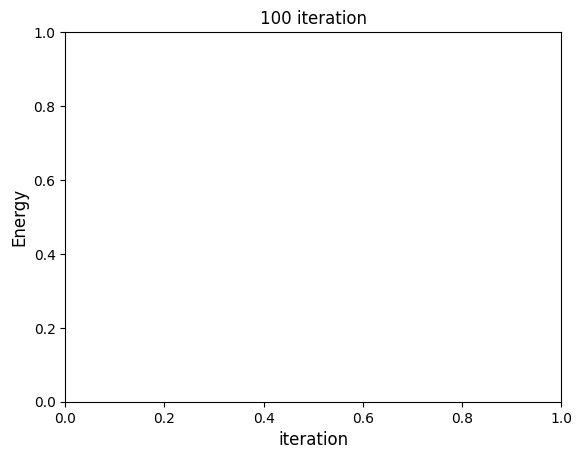

In [30]:
plt.xlabel('iteration', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.title("100 iteration", fontsize=12)
plt.axhline(y=gs, color="black", linestyle="--", label="True energy")
plt.plot(result)
#plt.savefig('100-dc-p=1.png')